In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import muax as mm
import src
from src.envs import HeatEnv
from src.fem import Topology
from const import *
from util import *
import numpy as np
import scipy.sparse as ss
from muax.test import test
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import haiku as hk
import src.heatnn as nn

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def adjm(n, m):
    num_nodes = n * m
    A = np.zeros((num_nodes, num_nodes), dtype=int)
    for i in range(num_nodes):
        r = i // m
        c = i % m
        if r > 0:
            A[i, i - m] = 1  
        if r < n - 1:
            A[i, i + m] = 1  
        if c > 0:
            A[i, i - 1] = 1  
        if c < m - 1:
            A[i, i + 1] = 1
    #for i in range(num_nodes):
    #    for j in range(num_nodes):
    #        if i%m == m-1 and j%m == m-1:
    #            A[i, j] = 0
    #            A[j, i] = 0
    A[0, 1] = 0
    A[1, 0] = 0
    A[2, 3] = 0
    A[3, 2] = 0
    A[-3, -4] = 0
    A[-4, -3] = 0
    A[-1, -2] = 0
    A[-2, -1] = 0
    return A

def incm(adjacency_matrix):
    num_nodes = adjacency_matrix.shape[0]
    edges = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adjacency_matrix[i, j] == 1:
                edges.append((i, j))
    num_edges = len(edges)
    incidence_matrix = np.zeros((num_nodes, num_edges), dtype=int)
    for edge_index, (start_node, end_node) in enumerate(edges):
        incidence_matrix[start_node, edge_index] = 1
        incidence_matrix[end_node, edge_index] = -1
    return incidence_matrix

def crtaj(d):
    fig = plt.figure()
    ax = fig.add_subplot()
    norm = Normalize(vmin=d.C.min(), vmax=d.C.max())
    cmap = plt.get_cmap('coolwarm')
    ax.scatter(d.coord[:, 0], d.coord[:, 1], s=5)
    for i in range(d.size):
        ax.plot(d.coord[d.G[:, [i]].indices, 0], d.coord[d.G[:, [i]].indices, 1], color=cmap(norm(d.C[i])))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    cbar = plt.colorbar(sm)
    cbar.set_label('C', rotation=90)

In [3]:
dima, dimb = 4, 4
A = incm(adjm(dima, dimb))
coord = np.vstack(i.flatten() for i in np.meshgrid(np.linspace(1, 10, dima), np.linspace(1, 10, dimb))).T

@jax.jit
def fun(x):
    return jnp.sqrt(jnp.sum(x**2))

cond = 0.01*np.ones((A.shape[1],))

/tmp/ipykernel_6113/1188322327.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  coord = np.vstack(i.flatten() for i in np.meshgrid(np.linspace(1, 10, dima), np.linspace(1, 10, dimb))).T


In [4]:
i = 1
support_size = 20
num_actions = 20

repr_fn = nn._init_representation_func(nn.Representation, 21, 5, 2, 7)
pred_fn = nn._init_prediction_func(nn.Prediction, 41, 21, 2, 7)
dy_fn = nn._init_dynamic_func(nn.Dynamic, 20, 41, 21, 2, 7)

tracer = mm.PNStep(50, 0.999, 0.5)
buffer = mm.TrajectoryReplayBuffer(500)

gradient_transform = mm.model.optimizer(init_value=0.002, peak_value=0.002, end_value=0.0005, warmup_steps=20000, transition_steps=20000)

# env = gym.make('src:Heat-v0', A=A, fun=fun, cond=cond)
# tenv = gym.make('src:Heat-v0', A=A, fun=fun, cond=cond)
model = mm.MuZero(repr_fn, pred_fn, dy_fn, policy='muzero', discount=0.999,
                    optimizer=gradient_transform, support_size=support_size)

# model_path = mm.fit(model,
#                     env=env,
#                     test_env=tenv,
#                     max_episodes=1_000,
#                     max_training_steps=1_000_000,
#                     tracer=tracer,
#                     buffer=buffer,
#                     k_steps=5,
#                     sample_per_trajectory=1,
#                     buffer_warm_up=128,
#                     num_trajectory=128,
#                     tensorboard_dir='tensorboard/',
#                     save_name='params',
#                     random_seed=i,
#                     log_all_metrics=True)

model.load('params/mcts.npy')

In [7]:
test_env = gym.make('src:Heat-v0', A=A, fun=fun, cond=cond)
test_key = jax.random.PRNGKey(0)
#err, best = test(model, test_env, test_key, num_simulations=1, num_test_episodes=1, random_seed=None)
test(model, test_env, test_key, num_simulations=1, num_test_episodes=1, random_seed=None)

-2966.504116654396

/tmp/ipykernel_6113/753777623.py:54: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


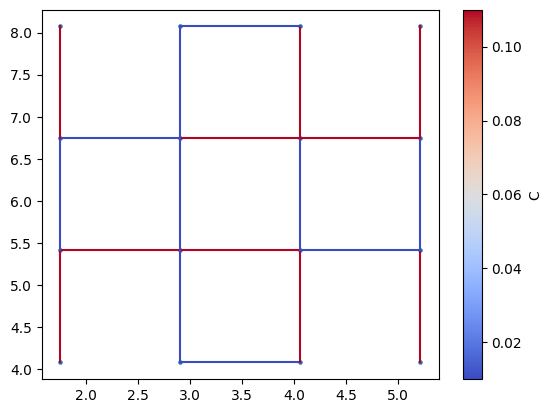

In [8]:
crtaj(test_env.design)